In [1]:
import torch
import os
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import torchvision.transforms as T
import numpy as np
from PIL import Image
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torchvision import models

sns.set_style("darkgrid")

In [2]:
if len(os.listdir('data/')) == 0:
    ZipFile("images_background.zip").extractall("data/")
    ZipFile("images_evaluation.zip").extractall("data/")



In [3]:
class OmniglotTrain(Dataset):

    def __init__(self, dataPath, transform=None):
        super(OmniglotTrain, self).__init__()
        np.random.seed(0)
        self.transform = transform
        self.datas, self.num_classes = self.loadToMem(dataPath)

    def loadToMem(self, dataPath):
        print("begin loading training dataset to memory")
        datas = {}
        agrees = [0, 90, 180, 270]
        idx = 0
        for agree in agrees:
            for alphaPath in os.listdir(dataPath):
                for charPath in os.listdir(os.path.join(dataPath, alphaPath)):
                    datas[idx] = []
                    for samplePath in os.listdir(os.path.join(dataPath, alphaPath, charPath)):
                        filePath = os.path.join(dataPath, alphaPath, charPath, samplePath)
                        datas[idx].append(Image.open(filePath).rotate(agree).convert('L'))
                    idx += 1
        print("finish loading training dataset to memory")
        return datas, idx

    def __len__(self):
        return  19800

    def __getitem__(self, index):
        # image1 = random.choice(self.dataset.imgs)
        label = None
        img1 = None
        img2 = None
        # get image from same class
        if index % 2 == 1:
            label = 1.0
            idx1 = random.randint(0, self.num_classes - 1)
            image1 = random.choice(self.datas[idx1])
            image2 = random.choice(self.datas[idx1])
        # get image from different class
        else:
            label = 0.0
            idx1 = random.randint(0, self.num_classes - 1)
            idx2 = random.randint(0, self.num_classes - 1)
            while idx1 == idx2:
                idx2 = random.randint(0, self.num_classes - 1)
            image1 = random.choice(self.datas[idx1])
            image2 = random.choice(self.datas[idx2])

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        return image1, image2, torch.from_numpy(np.array([label], dtype=np.float32))


In [4]:
transforms = T.Compose([
        T.RandomAffine(15),
        T.ToTensor()
    ])

train_dataset = OmniglotTrain('data/images_background',transform = transforms)
train_dataloader = DataLoader(train_dataset,16)

begin loading training dataset to memory
finish loading training dataset to memory


In [5]:
a,b,c = next(iter(train_dataloader)) # img1 , img2 , label
print(len(a),b[0].shape,c.shape,sep = '\n')
print(c[:5])

16
torch.Size([1, 105, 105])
torch.Size([16, 1])
tensor([[0.],
        [1.],
        [0.],
        [1.],
        [0.]])


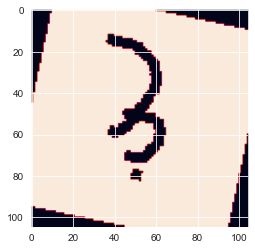

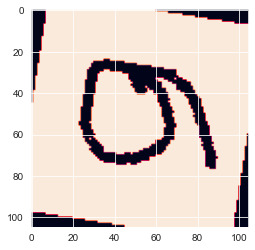

In [6]:
plt.imshow(a[0][0].numpy())
plt.show()

plt.imshow(b[0][0].numpy())
plt.show()

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class siamese_model(nn.Module):

    def __init__(self):
        super().__init__()
        self.input = nn.Conv2d(1,3,1)
        self.model_res = models.resnet50(pretrained=True)
        self.l1 = nn.Linear(1000, 128)
        self.out = nn.Linear(128, 1)

    def forward_one(self, x):
        x = self.model_res(F.relu(self.input(x)))
        x = x.view(x.size()[0], -1)
        x = self.l1(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)
        return torch.sigmoid(out)
    
device = 'cuda'

model = siamese_model()

model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr = 0.00006)

epoch = 50
loss_history = [[],[]]
accuracy_history = [[],[]]
train_n_minibatches = train_dataloader.__len__()

In [8]:
train_dataloader.__len__()

1238

In [9]:
for e in range(epoch):
    for batch_idx , (x , y , z) in enumerate(train_dataloader):
        model.train() # Setting mode to train
        optimizer.zero_grad()
        x , y , z = x.to(device) , y.to(device) , z.to(device)
        y_pred = model(x,y)
        
        # Calculating Loss
        loss = criterion(y_pred,z)
        loss.backward()
        optimizer.step()
        loss_history[0].append(float(loss.detach()))
        
        #Calaculating Accuracy
        correct = 0
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = z.cpu().detach().numpy().tolist()
        for i,j in zip(y,y_pred):
            if round(j[0]) == int(i[0]):
                correct = correct + 1
        accuracy_history[0].append((correct/x.shape[0])*100)

    # Saving the model progress
    torch.save(model.state_dict(),'saved_model/siamese_model_resnet')
    
    #Log for e+1th epoch
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    loss_history[1].append(sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches)
    accuracy_history[1].append(sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches)
    print(f'Loss for EPOCH {e+1}  TRAIN LOSS : {loss_history[1][-1]}',end = ' ')
    print(f'TRAIN ACCURACY : {accuracy_history[1][-1]}')
    print(f'---------------------------------------------------------------------------------------------')

---------------------------------------EPOCH 1-------------------------------------------
Loss for EPOCH 1  TRAIN LOSS : 0.4985425913516847 TRAIN ACCURACY : 75.10096930533118
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 2-------------------------------------------
Loss for EPOCH 2  TRAIN LOSS : 0.3998222941463521 TRAIN ACCURACY : 81.87096122778675
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 3-------------------------------------------
Loss for EPOCH 3  TRAIN LOSS : 0.33570564029097366 TRAIN ACCURACY : 85.17265751211632
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 4-------------------------------------------
Loss for EPOCH 4  TRAIN LOSS : 0.31381363230298526 TRAIN ACCURACY : 86.60642164781906
----------------

---------------------------------------EPOCH 32-------------------------------------------
Loss for EPOCH 32  TRAIN LOSS : 0.11097021394684574 TRAIN ACCURACY : 96.16316639741518
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 33-------------------------------------------
Loss for EPOCH 33  TRAIN LOSS : 0.11350629126738836 TRAIN ACCURACY : 95.88045234248789
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 34-------------------------------------------
Loss for EPOCH 34  TRAIN LOSS : 0.11620833363793248 TRAIN ACCURACY : 95.93093699515347
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 35-------------------------------------------
Loss for EPOCH 35  TRAIN LOSS : 0.10622256702889413 TRAIN ACCURACY : 96.24394184168013
------

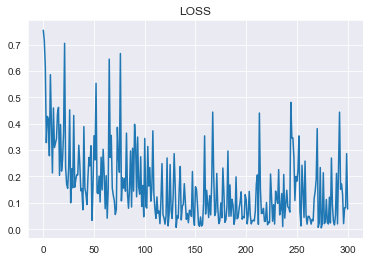

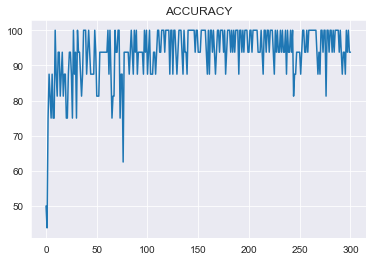

In [10]:
plt.plot(loss_history[0][::int(len(loss_history[0])/300)])
plt.title('LOSS')
plt.show()

plt.plot(accuracy_history[0][::int(len(accuracy_history[0])/300)])
plt.title('ACCURACY')
plt.show()

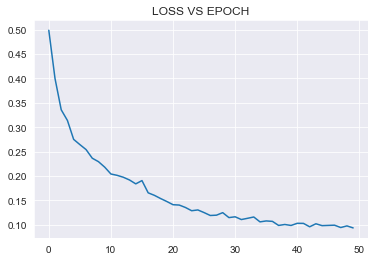

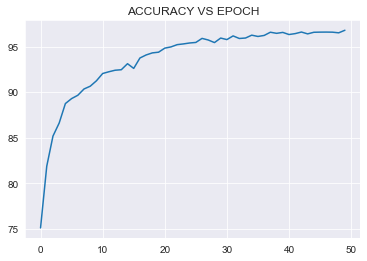

In [11]:
plt.plot(loss_history[1])
plt.title('LOSS VS EPOCH')
plt.show()

plt.plot(accuracy_history[1])
plt.title('ACCURACY VS EPOCH')
plt.show()